# PPO Algorithm

This code performs PPO on the Patrolling Zoo environment.

In [1]:
%reload_ext autoreload
%autoreload 2

import torch
from patrolling_zoo.patrolling_zoo_v0 import parallel_env, PatrolGraph
from algorithm.ppo import PPO

# set process priority low
import psutil
import os
if os.name == 'nt':
    psutil.Process(os.getpid()).nice(psutil.BELOW_NORMAL_PRIORITY_CLASS)
else:
    psutil.Process(os.getpid()).nice(10)

# Configuration

In [2]:
MAX_CYCLES = 500

""" ENV SETUP """
patrolGraph = PatrolGraph("patrolling_zoo/env/4nodes.graph")
env = parallel_env(patrolGraph, 2,
    require_explicit_visit = True,
    speed = 5,
    alpha = 1.0,
    max_cycles = MAX_CYCLES,
    observe_method = "ajg_new"
)

"""ALGO PARAMS"""
algo = PPO(
    env = env,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    ent_coef = 0.1,
    vf_coef = 0.1,
    clip_coef = 0.1,
    gamma = 0.99,
    lr = 1e-4,
    batch_size = 100,
    max_cycles = MAX_CYCLES,
    total_episodes = 20
)

# Training

In [3]:
stats = algo.train(seed=42)

Training episode 0
Episodic Return: -1323.2535400390625
Episode Length: 499

Training episode 1
Episodic Return: -695.507080078125
Episode Length: 499

Training episode 2
Episodic Return: 35.75505065917969
Episode Length: 499

Training episode 3
Episodic Return: 9.016311645507812
Episode Length: 499

Training episode 4
Episodic Return: 850.625
Episode Length: 499

Training episode 5
Episodic Return: 1078.842529296875
Episode Length: 499

Training episode 6
Episodic Return: 766.7701416015625
Episode Length: 499

Training episode 7
Episodic Return: 768.2938232421875
Episode Length: 499

Training episode 8
Episodic Return: 896.86279296875
Episode Length: 499

Training episode 9
Episodic Return: 176.09625244140625
Episode Length: 499

Training episode 10
Episodic Return: 234.31143188476562
Episode Length: 499

Training episode 11
Episodic Return: 1801.076904296875
Episode Length: 499

Training episode 12
Episodic Return: 585.5535888671875
Episode Length: 499

Training episode 13
Episodic R

In [4]:
algo.save()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

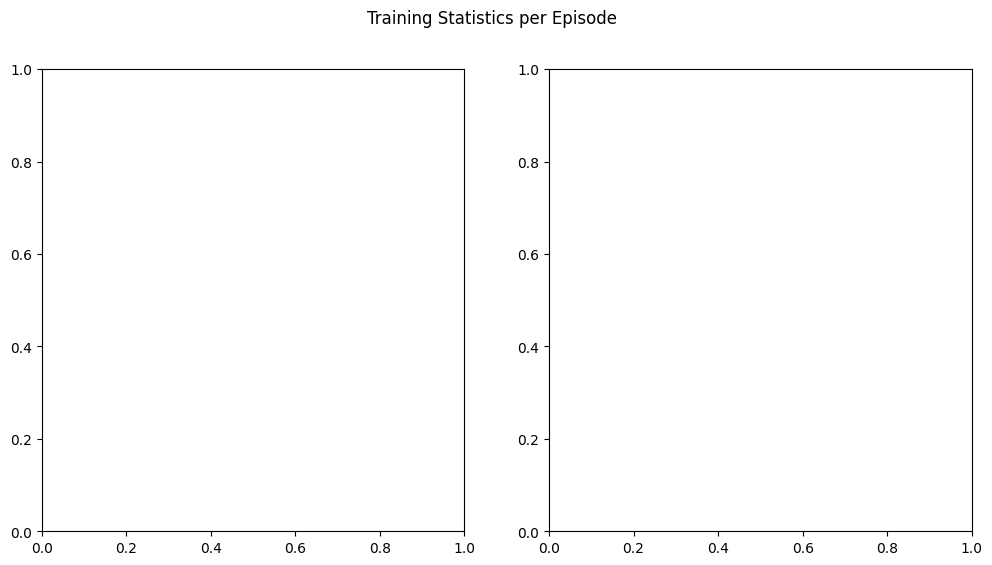

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
fig.suptitle("Training Statistics per Episode")

ax[0, 0].set_title("Reward vs. Episode")
ax[0, 0].plot(stats["episodic_return"])

ax[1, 0].set_title("Iterations vs. Episode")
ax[1, 0].plot(stats["episodic_length"])

plt.show()


fig, ax = plt.subplots(4, 2, sharex=True, figsize=(12, 10))
fig.suptitle("Training Statistics per Iteration")

ax[0, 1].set_title("Value Loss vs. Iteration")
ax[0, 1].plot(stats["value_loss"], label="value_loss")
# ax[0, 1].legend()

ax[1, 0].set_title("Policy Loss vs. Iteration")
ax[1, 0].plot(stats["policy_loss"], label="policy_loss")
# ax[1, 0].legend()

ax[1, 1].set_title("Entropy Loss vs. Iteration")
ax[1, 1].plot(stats["entropy_loss"], label="entropy_loss")
# ax[1, 1].legend()

ax[2, 0].set_title("Total Loss vs. Iteration")
ax[2, 0].plot(stats["total_loss"], label="total_loss")
# ax[2, 0].legend()

ax[2, 1].set_title("Approx. KL-Divergence vs. Iteration")
ax[2, 1].plot(stats["approx_kl"])

ax[3, 0].set_title("Clip Fraction vs. Iteration")
ax[3, 0].plot(stats["clip_frac"])

plt.show()


# Evaluation

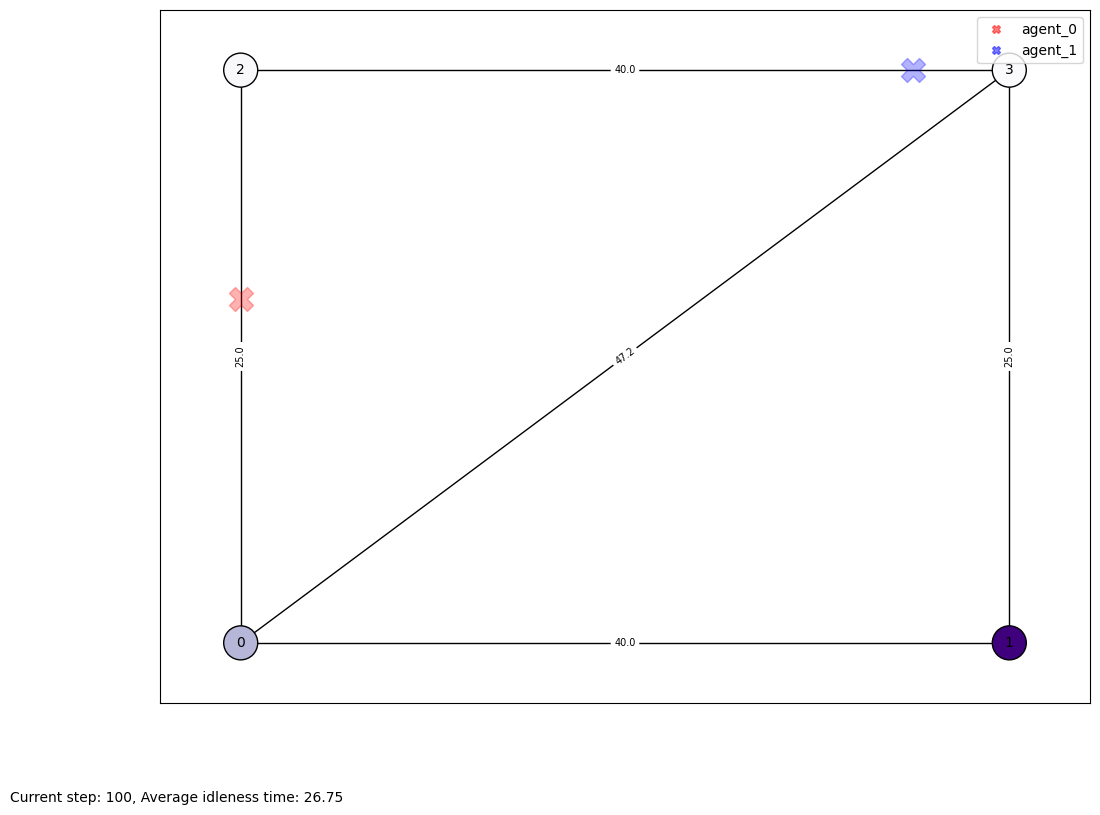

In [ ]:
algo.evaluate(render=True, max_cycles=100, seed=42)